In [1]:
import os
import numpy as np
import pandas as pd
import bambi
import arviz as az
import pymc3 as pm

import seaborn as sns
sns.set_context('paper')
sns.set_style("ticks")

import matplotlib.pyplot as plt
%matplotlib inline

from utils.stats import get_var, get, sem_p
from utils.plotting import despine, cm2inch, violin
from utils.general import make_sure_path_exists

# Descriptives & data

In [2]:
# directories
data_dir = '../data/'
mfx_dir = '../results/posterior_traces/mixed_effects_models/'
figure_dir = '../figures/'

# make sure output dir exists
make_sure_path_exists(figure_dir)
make_sure_path_exists(mfx_dir)

# choice set sizes
setsizes = np.array([9, 16, 25, 36])
setsizes = np.sort(setsizes)
colors = ['darkturquoise', 'orange', 'mediumseagreen', 'lightcoral']

# read in response data
data = []
for setsize in setsizes:
    df_setsize = pd.read_csv(data_dir+'summary_files/{}_data.csv'.format(setsize))
    df_setsize['setsize'] = setsize
    data.append(df_setsize)
data = pd.concat(data, sort=True)

# subject IDs
subjects = np.unique(data.subject)
n_subjects = subjects.size
    
# read in gaze data
gaze_data = []
for subject in subjects:
    for c in setsizes:
        tmp_data = pd.read_csv(
            data_dir+'subject_files/{}_{}_fixations.csv'.format(subject, c))
        tmp_data = tmp_data[[c for c in tmp_data.columns
                             if not 'Unnamed:' in c]]
        gaze_data.append(tmp_data)
gaze_data = pd.concat(gaze_data, sort=True)

In [3]:
data.head()

,best_chosen,best_seen_chosen,choice,fixation_count,fixation_onset_0,fixation_onset_1,fixation_onset_10,fixation_onset_11,fixation_onset_12,fixation_onset_13,...,stimulus_34,stimulus_35,stimulus_4,stimulus_5,stimulus_6,stimulus_7,stimulus_8,stimulus_9,subject,trial
0,1.0,1.0,1,18.0,1662.0,1238.0,NaN,NaN,NaN,NaN,...,NaN,NaN,nr62.png,nr125.png,nr63.png,nr113.png,nr27.png,NaN,0,2
1,1.0,1.0,0,14.0,907.0,625.0,NaN,NaN,NaN,NaN,...,NaN,NaN,nr76.png,nr93.png,nr79.png,nr4.png,nr92.png,NaN,0,3
2,1.0,1.0,1,20.0,893.0,503.0,NaN,NaN,NaN,NaN,...,NaN,NaN,nr56.png,nr91.png,nr30.png,nr106.png,nr121.png,NaN,0,7
3,1.0,1.0,3,12.0,773.0,4625.0,NaN,NaN,NaN,NaN,...,NaN,NaN,nr21.png,nr85.png,nr2.png,nr58.png,nr7.png,NaN,0,9
4,1.0,1.0,4,22.0,786.0,1010.0,NaN,NaN,NaN,NaN,...,NaN,NaN,nr69.png,nr81.png,nr79.png,nr58.png,nr28.png,NaN,0,14


In [4]:
gaze_data.head()

,choice,dur,fixnum,is_first,is_last,is_last_to_choice,is_refixation,item,onset,refixnum,setsize,stimulus,subject,trial,value
0,1,552,1,1.0,0.0,1,0,4,76,0.0,9,nr62.png,0,2,0
1,1,188,2,0.0,0.0,1,0,3,678,0.0,9,nr48.png,0,2,0
2,1,260,3,0.0,0.0,1,0,7,922,0.0,9,nr113.png,0,2,0
3,1,348,4,0.0,0.0,1,0,1,1238,0.0,9,nr10.png,0,2,2
4,1,326,5,0.0,0.0,1,0,0,1662,0.0,9,nr91.png,0,2,0


# P(item looked at | liking rating)

In [5]:
def plot_p_fix_vs_item_value(data,
                             gaze_data,
                             colors=None,
                             axs=None,
                             add_setsize_title=True,
                             set_legend=False,
                             return_single_subject_data=False):
    
    """Plot probability that items are looked at
    as a function of the items' liking ratings for each 
    choice set size condition in the data.
    
    Args:
        data (dataframe): choice data
        gaze_data (dataframe): gaze data
        colors (array of strings): set size colors for plotting;
            if None, colors are automatically generated
        axs (matplotlib axis object): matplotlib axis object;
            if None new axis object is created  
        add_setsize_title (bool): whether or not to
            label axess with choice set sizes
        set_legend (bool): whether or not to
            add axis legend    
        return_single_subject_data (bool): whether or not to 
            return an single-subject gaze data
                
    Returns
        axs (matplotlib axis object)
        dataframe of single-subject gaze data,
            if return_single_subject_data = True
    """
    
    # set up figure
    tighten_layout = False
    if axs is None:
        tighten_layout = True
        fig, axs = plt.subplots(1,4, figsize=cm2inch(18,6), dpi=330)
    
    # extract
    setsizes = data.setsize.unique()
    subjects = data.subject.unique()
    
    # define colors
    if colors is None:
        colors = ['C{}'.format(i) for i in range(len(setsizes))]
    
    # aggregate data
    item_seen_data = pd.DataFrame()
    for setsize in setsizes:
        setsize_gaze_data = gaze_data[gaze_data['setsize']==setsize].copy()
        for subject in subjects:
            subject_data = data[data['subject']==subject].copy()
            subject_gaze_data = setsize_gaze_data[setsize_gaze_data['subject']==subject].copy()
            n_trials = subject_gaze_data.trial.unique().size
            item_seen = np.zeros((n_trials, setsize))
            item_refixated = np.zeros_like(item_seen)
            item_value = np.zeros_like(item_seen)
            for ti, tr in enumerate(subject_gaze_data.trial.unique()):
                trial_data = subject_data[subject_data['trial']==tr].copy()
                trial_gaze_data = subject_gaze_data[subject_gaze_data['trial']==tr].copy()
                item_seen[ti,trial_gaze_data.item.unique()] = 1
                item_refixated[ti,trial_gaze_data[trial_gaze_data['is_refixation']==1]['item'].values] = 1
                item_value[ti] = get(trial_data, 'item_value')[0][:setsize]
            subject_df = pd.DataFrame(dict(subject=subject,
                                           setsize=setsize,
                                           item_value=item_value.ravel(),
                                           item_seen=item_seen.ravel(),
                                           item_refixated=item_refixated.ravel()))
            item_seen_data = pd.concat([item_seen_data, subject_df]) 
    
    # compute means
    means_item_seen = item_seen_data.groupby(
        ['setsize', 'subject','item_value']).item_seen.mean().groupby(
        ['setsize', 'item_value']).mean()
    means_item_refixated = item_seen_data.groupby(
        ['setsize', 'subject', 'item_value']).item_refixated.mean().groupby(
        ['setsize', 'item_value']).mean()
    
    # iterate set sizes 
    for si, setsize in enumerate(setsizes):
        
        # item seen
        if set_legend:
            label = 'initial'
        else:
            label = None
        axs[si].errorbar(np.arange(-3,4),
                         means_item_seen[setsize],
                         yerr=sem_p(means_item_seen[setsize], subjects.size),
                         ls = '-',
                         capsize=2,
                         c=colors[si],
                         label=label)
        
        # item refixated
        if set_legend:
            label = 'returning'
        else:
            label = None
        axs[si].errorbar(np.arange(-3,4),
                         means_item_refixated[setsize],
                         yerr=sem_p(means_item_refixated[setsize], subjects.size),
                         ls=':',
                         capsize=2,
                         c=colors[si],
                         label=label)
        
        # label axes
        if si == 0:
            axs[si].set_ylabel('P(item looked at)', fontsize=7)
        if set_legend:
            axs[-1].legend(loc='upper right', fontsize=6)
        axs[si].set_xlabel('Item liking rating', fontsize=7)
        axs[si].set_xticks(np.arange(-3,4))
        axs[si].set_xticklabels(np.arange(-3,4))
        axs[si].tick_params(axis='both', which='major',
                            labelsize=7)
        if add_setsize_title:
            axs[si].set_title('{} Items'.format(setsize),
                              fontsize=7)
        axs[si].set_ylim(0,1)
        despine(axs[si])
    
    if tighten_layout:
        fig.tight_layout()
    
    if return_single_subject_data:
        return axs, item_seen_data
    else:
        return axs

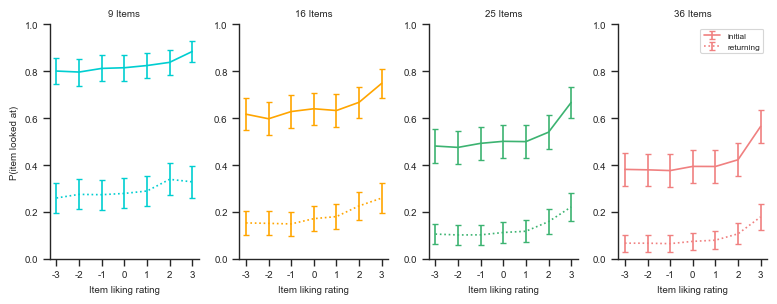

In [6]:
fig, axs = plt.subplots(1,4, figsize=cm2inch(20,8), dpi=100)
_, item_seen_data = plot_p_fix_vs_item_value(data,
                                             gaze_data,
                                             axs=axs,
                                             colors=colors,
                                             set_legend=True,
                                             return_single_subject_data=True)
fig.tight_layout()

## MFX: $P(fixated) \sim rating$

In [7]:
np.random.seed(1)
mfx_filename = 'p-item-seen_value_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    
    # make model
    samples = 2000
    burn = 500
    model_item_seen = bambi.Model(data=item_seen_data)
    model_item_seen.add('item_seen ~ item_value + setsize',
                        random=['1|subject',
                                '0+item_value|subject',
                                '0+setsize|subject'],
                        categorical=['subject'])

    # sample posterior
    item_seen_mfx_results = model_item_seen.fit(samples=samples,
                                                tune=burn,
                                                chains=2,
                                                backend='pymc',
                                                init='ADVI',
                                                n_init=50000,
                                                family='bernoulli',
                                                random_seed=1)
    
    # save results
    pm.trace_to_dataframe(model_item_seen.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(item_seen_mfx_results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    item_seen_mfx_summary = az.summary(item_seen_mfx_results, round_to='none')
    item_seen_mfx_summary.to_csv(mfx_dir+mfx_filename+'.csv')

else:
    print('Loading pre-computed posterior trace from: '+mfx_dir)
    item_seen_mfx_summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

# extract estimates
_ = get_var(item_seen_mfx_summary, 'Intercept[0]')
_ = get_var(item_seen_mfx_summary, 'item_value[0]')
_ = get_var(item_seen_mfx_summary, 'setsize[0]')

Loading pre-computed posterior trace from: ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 0.8819564714163959, 94% HPD: 0.8365169453350669, 0.9239998666809812
item_value[0]; Mean: 0.019600160917622563, 94% HPD: 0.015653644766038928, 0.0234072805689837
setsize[0]; Mean: -0.013872264105515009, 94% HPD: -0.014683292705169156, -0.013158133621400841


## MFX: $P(refixated) \sim rating$

In [8]:
np.random.seed(2)
mfx_filename = 'p-item-refixated_value_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    
    # make model
    samples = 2000
    burn = 500
    model_item_refixated = bambi.Model(data=item_seen_data)
    model_item_refixated.add('item_refixated ~ item_value + setsize',
                             random=['1|subject',
                                     '0+item_value|subject',
                                     '0+setsize|subject'],
                             categorical=['subject'])

    # sample posterior
    item_refixated_mfx_results = model_item_refixated.fit(samples=samples, 
                                                          tune=burn, 
                                                          chains=2,
                                                          backend='pymc',
                                                          init='ADVI',
                                                          n_init=50000,
                                                          family='bernoulli',
                                                          random_seed=2)

    # save results
    pm.trace_to_dataframe(model_item_refixated.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(item_refixated_mfx_results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    item_refixated_mfx_summary = az.summary(item_refixated_mfx_results, round_to='none')
    item_refixated_mfx_summary.to_csv(mfx_dir+mfx_filename+'.csv')
    
else:
    print('Loading pre-computed posterior trace from: '+mfx_dir)
    item_refixated_mfx_summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

# extract estimates
_ = get_var(item_refixated_mfx_summary, 'Intercept[0]')
_ = get_var(item_refixated_mfx_summary, 'item_value[0]')
_ = get_var(item_refixated_mfx_summary, 'setsize[0]')

Loading pre-computed posterior trace from: ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 0.30567019552925273, 94% HPD: 0.2626558595808859, 0.34849021483024784
item_value[0]; Mean: 0.016288141753376038, 94% HPD: 0.014198442534994013, 0.018428861704955758
setsize[0]; Mean: -0.006524815324370386, 94% HPD: -0.007448214013720233, -0.005510912913608085


# Gaze duration by liking rating

In [9]:
def plot_gaze_dur_vs_item_value(data,
                                gaze_data,
                                colors=None,
                                axs=None,
                                add_setsize_title=True,
                                set_legend=False,
                                return_single_subject_data=False):
    
    """Plot mean duration of all initial and returning gazes
    as a function of the items' liking ratings for each 
    choice set size condition in the data.
    
    Args:
        data (dataframe): choice data
        gaze_data (dataframe): gaze data
        colors (array of strings): set size colors for plotting;
            if None, colors are automatically generated
        axs (matplotlib axis object): matplotlib axis object;
            if None new axis object is created  
        add_setsize_title (bool): whether or not to
            label axess with choice set sizes
        set_legend (bool): whether or not to
            add axis legend    
        return_single_subject_data (bool): whether or not to 
            return an single-subject gaze data
                
    Returns
        axs (matplotlib axis object)
    """
    
    # set up figure
    tighten_layout = False
    if axs is None:
        tighten_layout = True
        fig, axs = plt.subplots(1,4, figsize=cm2inch(20,8), dpi=330)
    
    # extract
    setsizes = data.setsize.unique()
    subjects = data.subject.unique()
    
    # define colors
    if colors is None:
        colors = ['C{}'.format(i) for i in range(len(setsizes))]
    
    # compute means
    means_dur = gaze_data.groupby(
        ['setsize', 'subject', 'trial', 'value','is_refixation']).dur.mean().groupby(
        ['setsize', 'subject', 'value', 'is_refixation']).mean().groupby(
        ['setsize', 'is_refixation', 'value']).mean()
    sems_dur = gaze_data.groupby(
        ['setsize', 'subject', 'trial', 'value', 'is_refixation']).dur.mean().groupby(
        ['setsize', 'subject', 'value', 'is_refixation']).mean().groupby(
        ['setsize', 'is_refixation', 'value']).sem()

    # iterate set sizes
    for si, setsize in enumerate(setsizes):
        
        # initial gazes
        if set_legend:
            label = 'initial'
        else:
            label = None
        axs[si].errorbar(np.arange(-3, 4),
                         means_dur[setsize][0],
                         yerr=sems_dur[setsize][0],
                         capsize=2,
                         ls = '-',
                         c=colors[si],
                         label=label)
            
        # re-fixations
        if set_legend:
            label = 'returning'
        else:
            label = None
        axs[si].errorbar(np.arange(-3, 4),
                         means_dur[setsize][1],
                         yerr=sems_dur[setsize][1],
                         capsize=2,
                         ls=':',
                         c=colors[si],
                         label=label)
        
        # label axes
        if si == 0:
            if set_legend:
                axs[si].legend(loc='lower left', frameon=False, fontsize=6)
            axs[si].set_ylabel('Mean gaze duration (ms)', fontsize=7)
        axs[si].set_xlabel('Item liking rating', fontsize=7)
        axs[si].set_xticks(np.arange(-3,4))
        axs[si].set_xticklabels(np.arange(-3,4))
        axs[si].tick_params(axis='both', which='major', labelsize=7)
        if add_setsize_title:
            axs[si].set_title('{} Items'.format(setsize),
                              fontsize=7)
        axs[si].set_ylim(0, 400)
        despine(axs[si])

    if tighten_layout: 
        fig.tight_layout()
    return axs

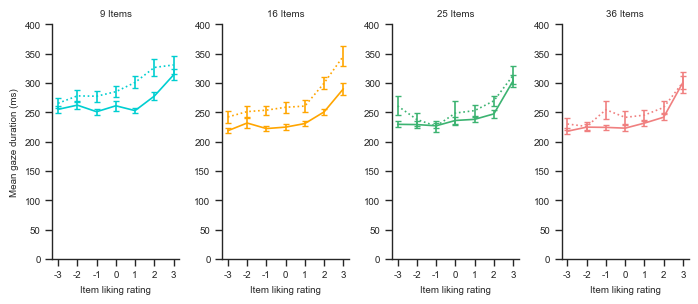

In [10]:
fig, axs = plt.subplots(1,4,figsize=cm2inch(18,8),dpi=100)
plot_gaze_dur_vs_item_value(data, gaze_data, axs=axs, colors=colors)
fig.tight_layout()

## MFX: $Dur(gaze) \sim rating$

In [11]:
np.random.seed(3)
mfx_filename = 'gaze-dur_value_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    
    # make model
    samples = 2000
    burn = 500
    model_fix_dur_first = bambi.Model(data=gaze_data.copy())
    model_fix_dur_first.add('dur ~ value ',
                            random=['1|subject',
                                    '0+value|subject'],
                            categorical=['subject'])

    # sample posterior
    fix_dur_first_mfx_results = model_fix_dur_first.fit(samples=samples,
                                                        tune=burn,
                                                        chains=2,
                                                        backend='pymc',
                                                        init='ADVI',
                                                        n_init=50000,
                                                        random_seed=3)

    # save results
    pm.trace_to_dataframe(model_fix_dur_first.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(fix_dur_first_mfx_results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    fix_dur_first_mfx_summary = az.summary(fix_dur_first_mfx_results, round_to='none')
    fix_dur_first_mfx_summary.to_csv(mfx_dir+mfx_filename+'.csv')

else:
    print('Loading pre-computed posterior trace from: '+mfx_dir)
    fix_dur_first_mfx_summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

# extract estimates
_ = get_var(fix_dur_first_mfx_summary, 'Intercept[0]')
_ = get_var(fix_dur_first_mfx_summary, 'value[0]')

Loading pre-computed posterior trace from: ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 249.8627553882418, 94% HPD: 240.54781980578895, 258.80835716121595
value[0]; Mean: 10.68405542744299, 94% HPD: 8.0696227775938, 13.393357213458819


## MFX: $Dur(gaze) \sim setsize$

In [12]:
np.random.seed(4)
mfx_filename = 'gaze-dur_setsize_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    
    # make model
    samples = 2000
    burn = 500
    model_fix_dur_first = bambi.Model(data=gaze_dur_data.copy())
    model_fix_dur_first.add('dur ~ setsize',
                            random=['1|subject',
                                    '0+setsize|subject'],
                            categorical=['subject'])

    # sample posterior
    fix_dur_first_mfx_results = model_fix_dur_first.fit(samples=samples,
                                                        tune=burn,
                                                        chains=2,
                                                        backend='pymc',
                                                        init='ADVI',
                                                        n_init=50000,
                                                        random_seed=4)

    # save results
    pm.trace_to_dataframe(model_fix_dur_first.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(fix_dur_first_mfx_results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    fix_dur_first_mfx_summary = az.summary(fix_dur_first_mfx_results, round_to='none')
    fix_dur_first_mfx_summary.to_csv(mfx_dir+mfx_filename+'.csv')

else:
    print('Loading pre-computed posterior trace from: '+mfx_dir)
    fix_dur_first_mfx_summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

# extract estimates
_ = get_var(fix_dur_first_mfx_summary, 'Intercept[0]')
_ = get_var(fix_dur_first_mfx_summary, 'setsize[0]')

Loading pre-computed posterior trace from: ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 280.4698917701632, 94% HPD: 269.5342790474688, 291.4225825977153
setsize[0]; Mean: -1.165154005981026, 94% HPD: -1.388946841201055, -0.9434267936254476


## MFX: $Dur(gaze) \sim gaze\_number$

In [13]:
np.random.seed(5)
mfx_filename = 'gaze-dur_gaze-num_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    
    # make model
    samples = 2000
    burn = 500
    model_dur_last_choice_vs_middle = bambi.Model(data=gaze_data)
    model_dur_last_choice_vs_middle.add('dur ~ fixnum',
                                        random=['1|subject',
                                                '0+fixnum|subject'],
                                        categorical=['subject'])

    # sample posterior
    dur_last_choice_vs_middle_mfx_results = model_dur_last_choice_vs_middle.fit(samples=samples,
                                                                                tune=burn,
                                                                                chains=2,
                                                                                backend='pymc',
                                                                                init='ADVI',
                                                                                n_init=50000,
                                                                                random_seed=5)

    # save results
    pm.trace_to_dataframe(model_dur_last_choice_vs_middle.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(dur_last_choice_vs_middle_mfx_results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    dur_last_choice_vs_middle_mfx_summary = az.summary(dur_last_choice_vs_middle_mfx_results, round_to='none')
    dur_last_choice_vs_middle_mfx_summary.to_csv(mfx_dir+mfx_filename+'.csv')
    
else:
    print('Loading pre-computed posterior trace from: '+mfx_dir)
    dur_last_choice_vs_middle_mfx_summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

# extract estimates
_ = get_var(dur_last_choice_vs_middle_mfx_summary, 'Intercept[0]')
_ = get_var(dur_last_choice_vs_middle_mfx_summary, 'fixnum[0]')

Loading pre-computed posterior trace from: ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 243.40787729378383, 94% HPD: 235.0605555914597, 252.5333941861729
fixnum[0]; Mean: 0.792014703954857, 94% HPD: 0.3553989050847708, 1.2484792384942058


# Gaze duration by gaze type

In [14]:
def compute_gaze_dur_means(data, n_subjects=49):
    """Compute mean gaze duration of gazes
    included in data; for each set
    size condition in the input data.
    
    Args:
        data (dataframe): choice data 
        n_subjects (int): number of subjects
            in the data
            
    Returns:
        subject_means (ndarray): single subject gaze duration means
            per set size condition (n_conditions x n_subjects)  
        means (ndarray): mean over subjects
        sems (ndarray): standard errors of means
    """
    
    df = data.copy()
    setsizes = df.setsize.unique()
    setsizes = np.sort(setsizes)
    
    subject_means = np.zeros((setsizes.size, n_subjects)) * np.nan
    df_tmp = df.groupby(
        ['setsize', 'subject', 'trial']).dur.mean().groupby(
        ['setsize', 'subject']).mean()
    for si, setsize in enumerate(setsizes):
        df_si = df_tmp[setsize]
        for subject in df_si.index:
            subject_means[si,subject] = df_si.loc[subject]
        
    grand_means = df_tmp.groupby(['setsize']).mean()
    grand_sems = df_tmp.groupby(['setsize']).sem()
    
    return subject_means, grand_means, grand_sems

In [15]:
def plot_gaze_dur_by_type(data,
                          gaze_data,
                          colors=None,
                          axs=None,
                          add_setsize_title=True):
    
    """ Plot mean gaze duration of the following gaze types 
    for each set size condition:
        - initial
        - returning
        - middle (all other gazes than first and last gaze of a trial)
        - last (in two conditions: to choice; not to choice).
    
    Args:
        data (dataframe): choice data
        gaze_data (dataframe): gaze data
        colors (array of strings): set size colors for plotting;
            if None, colors are automatically generated
        axs (matplotlib axis object): matplotlib axis object;
            if None new axis object is created  
        add_setsize_title (bool): whether or not to
            label axess with choice set sizes
                
    Returns:
        axs (matplotlib axis object)
    """
    
    # set up figure
    tighten_layout = False
    if axs is None:
        tighten_layout = True
        fig, axs = plt.subplots(1,4, figsize=cm2inch(20,8), dpi=330, sharey=True)
    
    # extract
    setsizes = data.setsize.unique()
    subjects = data.subject.unique()
    
    # define colors
    if colors is None:
        colors = ['C{}'.format(i) for i in range(len(setsizes))]
    
    # initial gazes
    gaze_data_initial = gaze_data[np.logical_and(
            gaze_data['is_refixation']==0, np.logical_and(gaze_data['is_last']==0,
                                                          gaze_data['is_first']==0))].copy()
    (sub_means_dur_initial,
     means_dur_initial,
     sems_dur_initial) = compute_gaze_dur_means(gaze_data_initial)

    # re-fixations
    gaze_data_refixation = gaze_data[np.logical_and(
            gaze_data['is_refixation']==1, np.logical_and(gaze_data['is_last']==0,
                                                          gaze_data['is_first']==0))].copy()
    (sub_means_dur_refixation, 
     means_dur_refixation,
     sems_dur_refixation) = compute_gaze_dur_means(gaze_data_refixation)
    
    # last gazes to choice
    gaze_data_last_choice = gaze_data[np.logical_and(gaze_data['is_last']==1,
                                                     gaze_data['is_last_to_choice']==1)].copy()
    (sub_means_dur_last_choice,
     means_dur_last_choice,
     sems_dur_last_choice) = compute_gaze_dur_means(gaze_data_last_choice)
    
    # last gazes to other
    gaze_data_last_other = gaze_data[np.logical_and(gaze_data['is_last']==1,
                                                    gaze_data['is_last_to_choice']==0)].copy()
    (sub_means_dur_last_other,
     means_dur_last_other,
     sems_dur_last_other) = compute_gaze_dur_means(gaze_data_last_other)
    
    # violin plots
    for si, setsize in enumerate(setsizes):
        
        df_tmp = pd.DataFrame(
            np.concatenate(
                [sub_means_dur_initial[si][:,None],
                 sub_means_dur_refixation[si][:,None],
                 sub_means_dur_last_choice[si][:,None],
                 sub_means_dur_last_other[si][:,None]], axis=1))
        df_tmp = df_tmp.dropna(axis=0)
        axs[si] = violin(df_tmp, ax=axs[si], palette=[colors[si]]*4)

        # label axes
        if si == 0:
            axs[si].legend(loc='upper left', frameon=False, fontsize=6)
            axs[si].set_ylabel('Mean gaze duration (ms)', fontsize=7)
        else:
            axs[si].set_ylabel('', fontsize=8)
        axs[si].set_xlabel('', fontsize=8)
        axs[si].set_xticks([0, 1, 2, 3])
        axs[si].set_xticklabels(['initial', 
                                 'returning',
                                 'last to choice',
                                 'last to other'], rotation=90, fontsize=7)
        axs[si].tick_params(axis='both', which='major', labelsize=7)
        if add_setsize_title:
            axs[si].set_title('{} Items'.format(setsize), fontsize=7)
        axs[si].set_xlim(-0.5,3.5)
        axs[si].set_ylim(0, 1000)
        despine(axs[si])

    if tighten_layout:
        fig.tight_layout()
        
    return axs

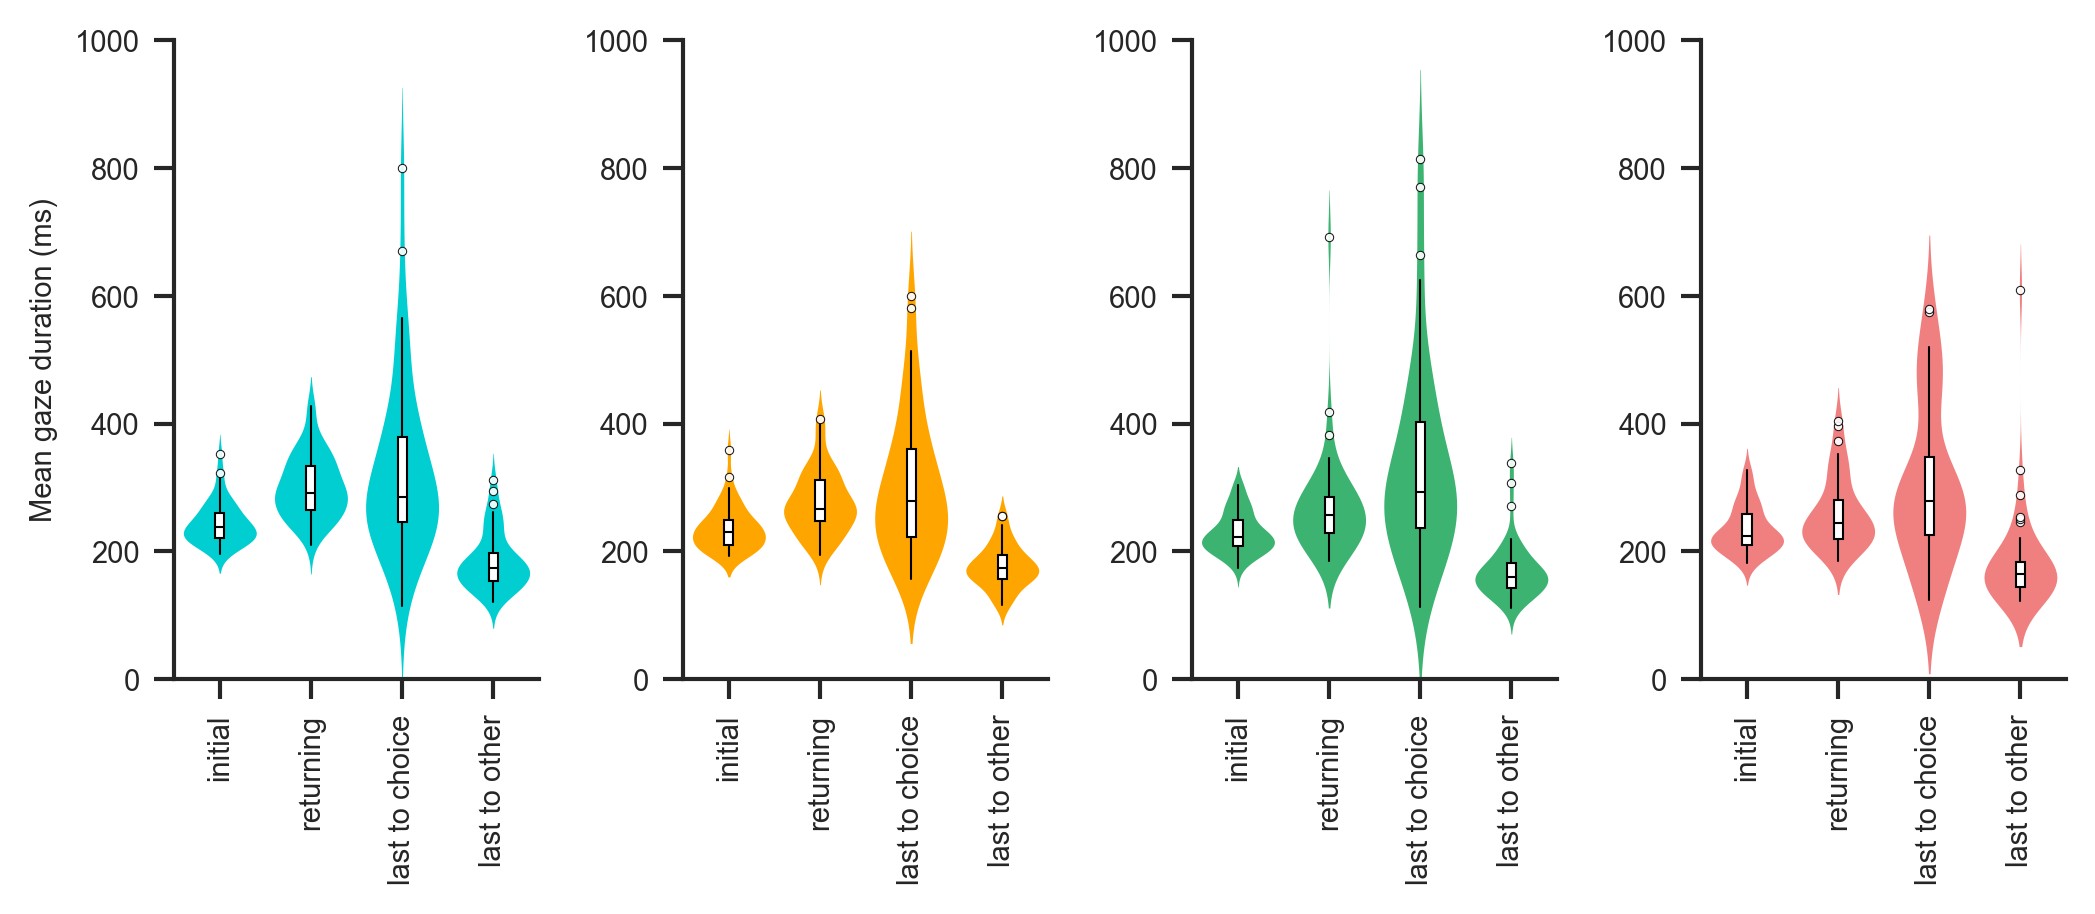

In [16]:
fig, axs = plt.subplots(1,4,figsize=cm2inch(18,8),dpi=300, sharey=True)
plot_gaze_dur_by_type(data, gaze_data, axs=axs, colors=colors, add_setsize_title=False)
fig.tight_layout()

## MFX: $Dur(initial\_gaze) : Dur(returning\_gaze)$

In [17]:
np.random.seed(6)
mfx_filename = 'gaze-dur_initial-vs-refix_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    
    # make model
    samples = 2000
    burn = 500
    model_dur_initial_vs_refix = bambi.Model(data=gaze_data[gaze_data['is_last']==0].copy())
    model_dur_initial_vs_refix.add('dur ~ is_refixation',
                            random=['1|subject',
                                    '0+is_refixation|subject'],
                            categorical=['subject'])

    # sample posterior
    dur_initial_vs_refix_mfx_results = model_dur_initial_vs_refix.fit(samples=samples,
                                                                      tune=burn,
                                                                      chains=2,
                                                                      backend='pymc',
                                                                      init='ADVI',
                                                                      n_init=50000,
                                                                      random_seed=6)

    # save results
    pm.trace_to_dataframe(model_dur_initial_vs_refix.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(dur_initial_vs_refix_mfx_results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    dur_initial_vs_refix_mfx_summary = az.summary(dur_initial_vs_refix_mfx_results, round_to='none')
    dur_initial_vs_refix_mfx_summary.to_csv(mfx_dir+mfx_filename+'.csv')
    
else:
    print('Loading pre-computed posterior trace from: '+mfx_dir)
    dur_initial_vs_refix_mfx_summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

# extract estimates
_ = get_var(dur_initial_vs_refix_mfx_summary, 'Intercept[0]')
_ = get_var(dur_initial_vs_refix_mfx_summary, 'is_refixation[0]')

Loading pre-computed posterior trace from: ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 242.5836323928285, 94% HPD: 234.07695662134998, 251.47272037540645
is_refixation[0]; Mean: 44.33566164298574, 94% HPD: 37.200365207820745, 51.2536592682216


## MFX: $Dur(last\_gaze\_to\_choice) : Dur(last\_gaze\_to\_other)$

In [18]:
np.random.seed(7)
mfx_filename = 'gaze-dur_last-to-choice-vs-other_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    
    # make model
    samples = 2000
    burn = 500
    model_dur_last_choice_vs_other = bambi.Model(data=gaze_data[gaze_data['is_last']==1].copy())
    model_dur_last_choice_vs_other.add('dur ~ is_last_to_choice',
                                        random=['1|subject',
                                                '0+is_last_to_choice|subject'],
                                        categorical=['subject'])

    # sample posterior
    dur_last_choice_vs_other_mfx_results = model_dur_last_choice_vs_other.fit(samples=samples,
                                                                                tune=burn,
                                                                                chains=2,
                                                                                backend='pymc',
                                                                                init='ADVI',
                                                                                n_init=50000,
                                                                                random_seed=7)

    # save results
    pm.trace_to_dataframe(model_dur_last_choice_vs_other.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(dur_last_choice_vs_other_mfx_results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    dur_last_choice_vs_other_mfx_summary = az.summary(dur_last_choice_vs_other_mfx_results, round_to='none')
    dur_last_choice_vs_other_mfx_summary.to_csv(mfx_dir+mfx_filename+'.csv')
    
else:
    print('Loading pre-computed posterior trace from: '+mfx_dir)
    dur_last_choice_vs_other_mfx_summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

# extract estimates
_ = get_var(dur_last_choice_vs_other_mfx_summary, 'Intercept[0]')
_ = get_var(dur_last_choice_vs_other_mfx_summary, 'is_last_to_choice[0]')

Loading pre-computed posterior trace from: ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 180.0857216221524, 94% HPD: 166.98481016521274, 192.06524870241557
is_last_to_choice[0]; Mean: 162.22482737398306, 94% HPD: 121.85336867159491, 200.97211822203855


# Figure 2

In [19]:
def figure_2(data, gaze_data, colors=None):
    """Create figure 2 of the manuscript.
    
    Args:
        data (dataframe): choice data
        colors (array of strings): set size colors for plotting;
            if None, colors are automatically generated
        gaze_data (dataframe): gaze data
            
    Returns:
        Matplotlib figure and axis
    """
         
    fig, axs = plt.subplots(3,4, figsize=cm2inch(16,16), dpi=300, sharey='row')
    
    # P(item looked at | liking rating)
    plot_p_fix_vs_item_value(data, gaze_data, axs=axs[0],colors=colors,
                             add_setsize_title=True, set_legend=True)

    # gaze duration vs item liking rating
    plot_gaze_dur_vs_item_value(data, gaze_data, axs=axs[1],colors=colors,
                                add_setsize_title=False, set_legend=False)
    
    # gaze duration by type
    plot_gaze_dur_by_type(data, gaze_data, axs=axs[2], colors=colors, 
                          add_setsize_title=False)
    
    # index axes
    for label, ax in zip(list('ABCDEFGHIJKLM'), axs.ravel()):
        ax.text(-0.45, 1.15, label, transform=ax.transAxes,
                fontsize=10, fontweight='bold', va='top')
        
    fig.tight_layout()
    
    return fig, axs

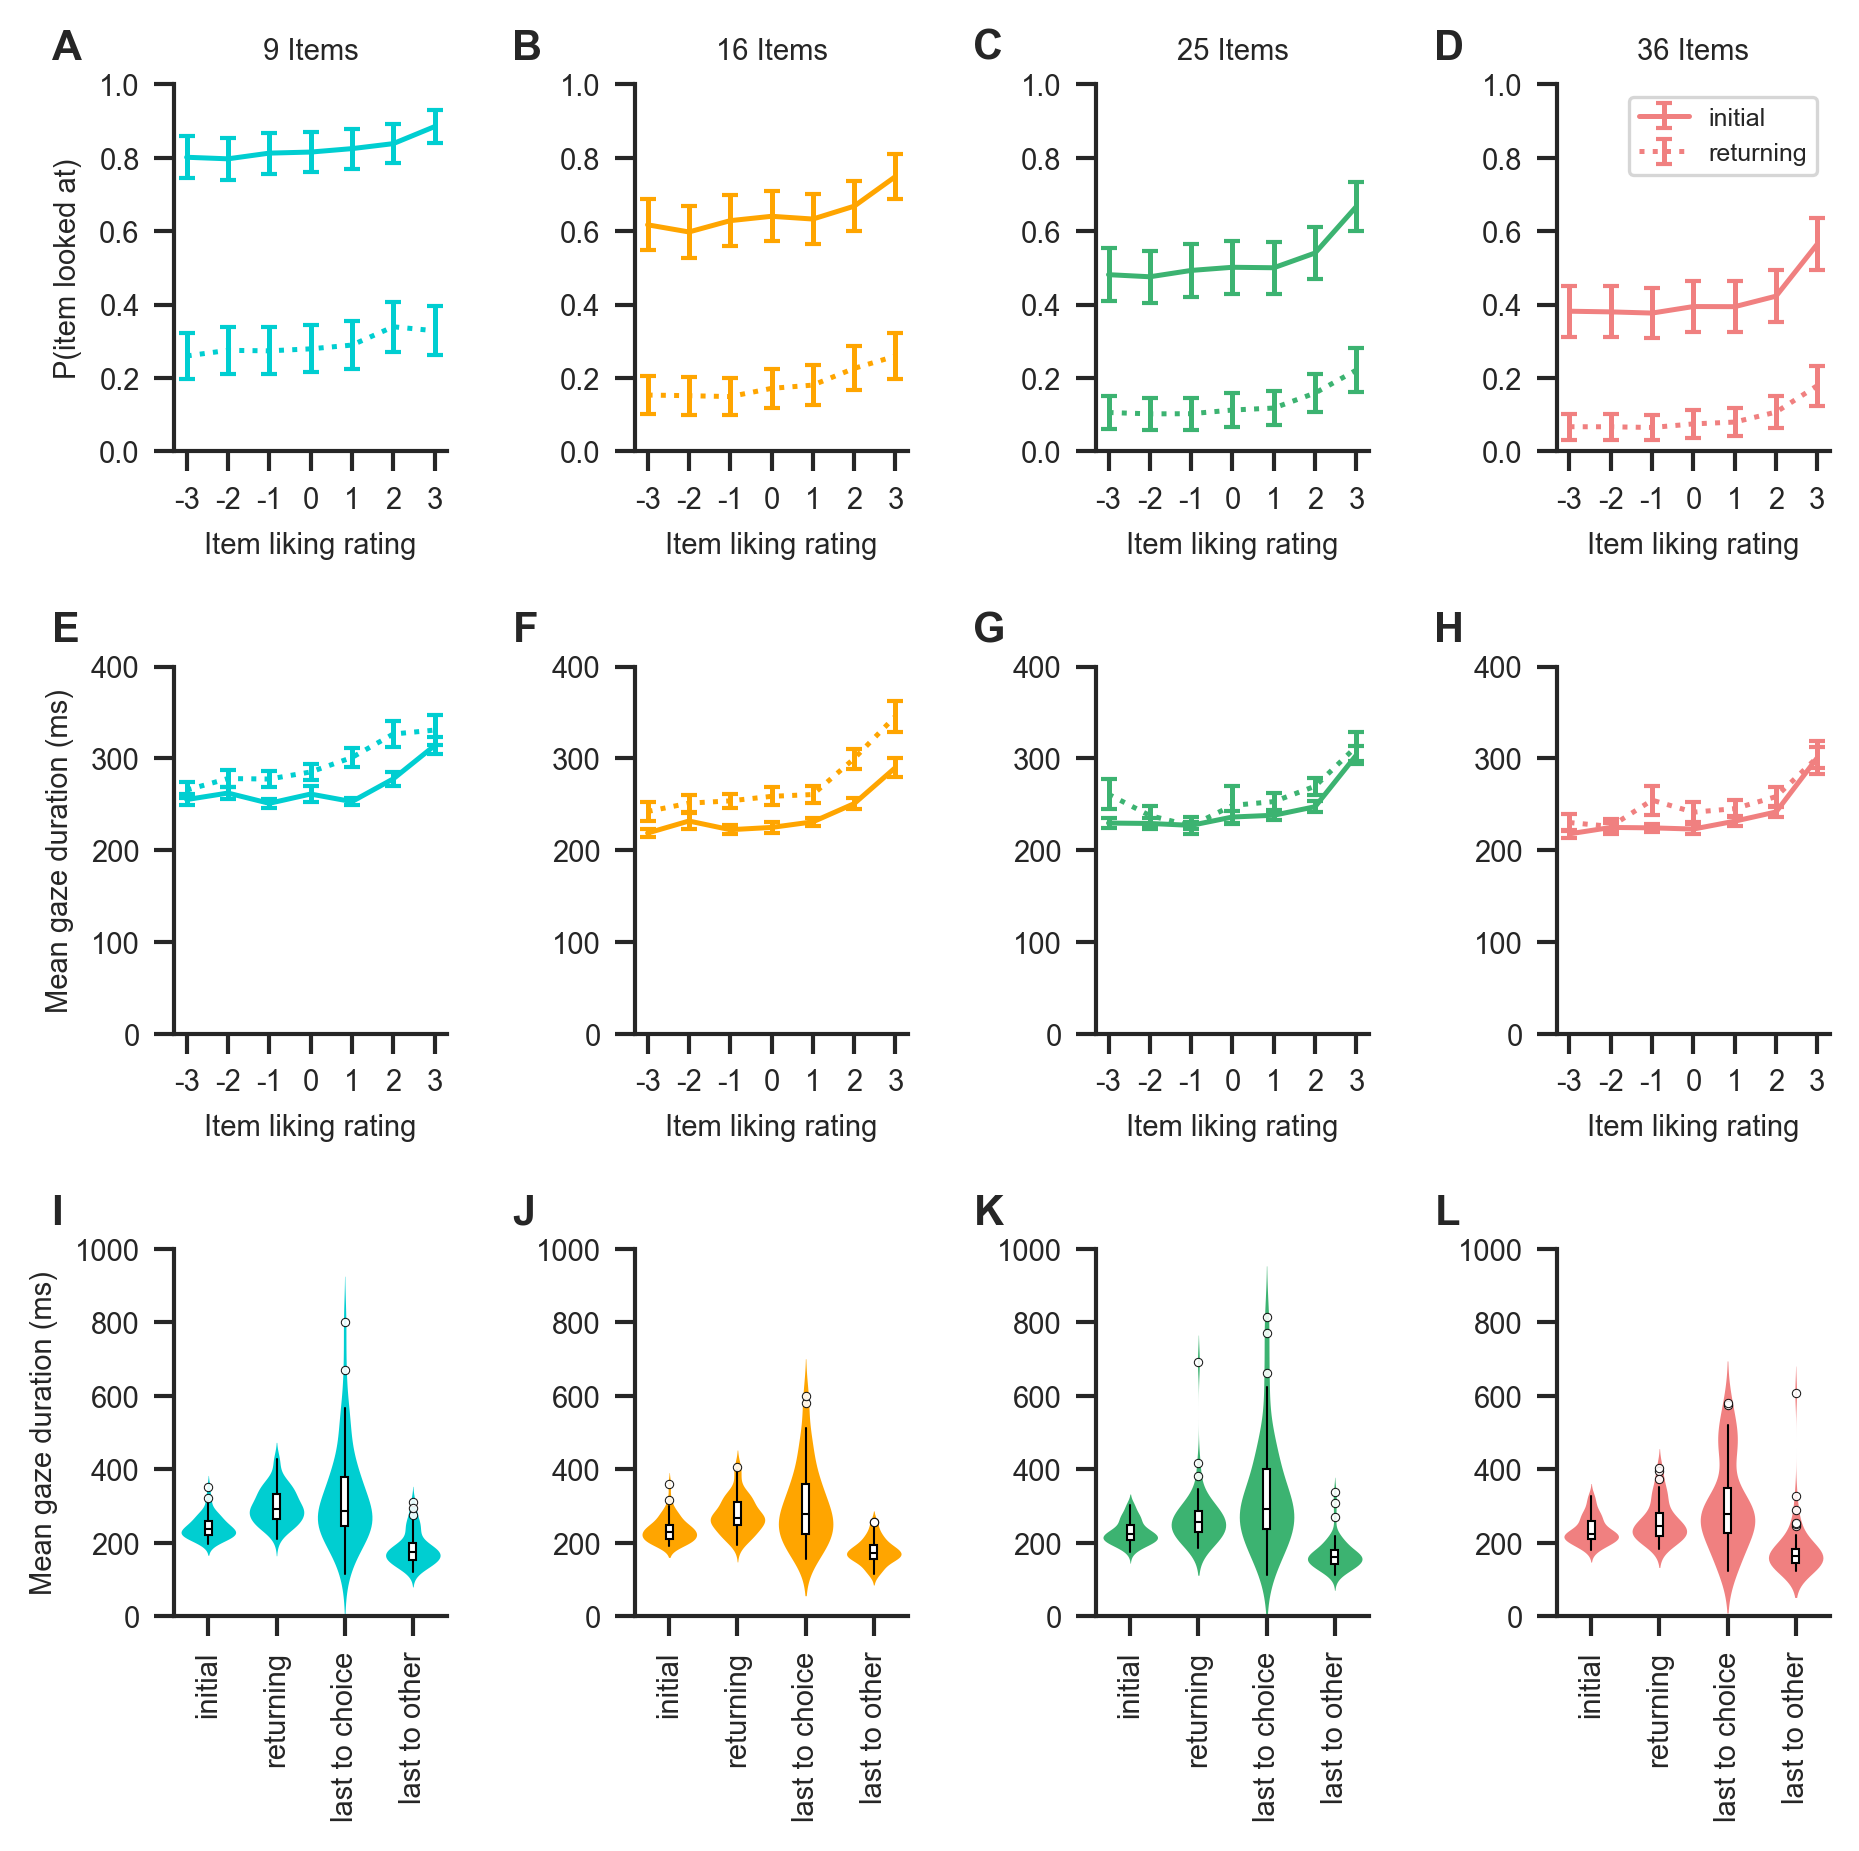

In [20]:
fig, _ = figure_2(data, gaze_data, colors=colors)
fig.savefig(figure_dir+'Figure-2_gaze-psychometrics.pdf', dpi=300)
fig.savefig(figure_dir+'Figure-2_gaze-psychometrics.jpg', dpi=300)
fig.savefig(figure_dir+'Figure-2_gaze-psychometrics.png', dpi=300)